# Daily Load Forecasting with Cyclic Time Features (DNN)

This notebook trains a small DNN on 1-minute interval load data for a single day.

**Expected file**: `1min_load_linear.xlsx` with columns:
- `time_of_day` (string or Excel time like `00:00:00`)
- `average_load` (float)


## Section 0: Settings
Adjust training ratio, epochs, and hidden-layer sizes here.

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, callbacks
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

# === Section 0: Settings ===
TRAIN_RATIO = 0.70
EPOCHS = 500
HIDDEN_LAYERS = [64, 32, 128]   # can be changed to [64, 32] or other sizes

## 1) Read Excel data
Update `excel_path` if needed.

In [12]:
# === 1. Read Excel data ===
excel_path = '1min_load_linear.xlsx'  # change as needed
df = pd.read_excel(excel_path)
assert {'time_of_day','average_load'}.issubset(df.columns), 'Excel must have time_of_day and average_load columns'

## 2) Parse `time_of_day` to seconds
Coerce to `timedelta` and take total seconds for robust parsing.

In [13]:
# --- Robustly parse time to seconds ---
t_seconds = pd.to_timedelta(df['time_of_day'].astype(str), errors='coerce').dt.total_seconds()
assert t_seconds.notna().all(), 'Failed to parse time_of_day. Please check the original column format.'
df = df.assign(t_sec=t_seconds)

## 3) Train/Test split
Random split by index, then sort each subset by `t_sec` so the x-axis is monotonic for plotting.

In [14]:
# === 2. Train/test split ===
N = len(df)
rng = np.random.default_rng(42)
idx = np.arange(N)
rng.shuffle(idx)
cut = int(N * TRAIN_RATIO)
train_idx, test_idx = idx[:cut], idx[cut:]

train_df = df.iloc[train_idx].sort_values('t_sec').reset_index(drop=True)
test_df  = df.iloc[test_idx].sort_values('t_sec').reset_index(drop=True)

## 4) Cyclic time features
Encode 24-hour periodicity with sine and cosine.

In [15]:
# === 3. Cyclic time features (encode 24h periodicity) ===
T = 24 * 60 * 60  # seconds per day
def make_time_features(sec):
    ang = 2 * np.pi * sec / T
    return np.c_[np.sin(ang), np.cos(ang)]

X_train = make_time_features(train_df['t_sec'].values)
X_test  = make_time_features(test_df['t_sec'].values)

y_train = train_df['average_load'].values.reshape(-1, 1)
y_test  = test_df['average_load'].values.reshape(-1, 1)

# Scale y for more stable optimization
y_mean, y_std = y_train.mean(), y_train.std()
y_train_s = (y_train - y_mean) / (y_std + 1e-8)
y_test_s  = (y_test  - y_mean) / (y_std + 1e-8)

print('X_train shape:', X_train.shape)
print('X_train (first 5 rows):\n', X_train[:5])

X_train shape: (1007, 2)
X_train (first 5 rows):
 [[0.         1.        ]
 [0.00436331 0.99999048]
 [0.00872654 0.99996192]
 [0.01745241 0.9998477 ]
 [0.02617695 0.99965732]]


## 5) Build and train the DNN
We use ReLU layers and add EarlyStopping/ReduceLROnPlateau for stability.

In [16]:
# === 4. Model ===
model = keras.Sequential([layers.Input(shape=(2,))])
for h in HIDDEN_LAYERS:
    model.add(layers.Dense(h, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

cb = [
    callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-5)
]

history = model.fit(
    X_train, y_train_s,
    validation_split=0.1,
    epochs=EPOCHS,
    batch_size=32,
    verbose=1,
    callbacks=cb
)

Epoch 1/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8128 - mae: 0.7409 - val_loss: 0.1577 - val_mae: 0.3878 - learning_rate: 0.0010
Epoch 2/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0547 - mae: 0.1981 - val_loss: 0.0129 - val_mae: 0.1097 - learning_rate: 0.0010
Epoch 3/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0085 - mae: 0.0742 - val_loss: 0.0282 - val_mae: 0.1661 - learning_rate: 0.0010
Epoch 4/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - mae: 0.0478 - val_loss: 0.0077 - val_mae: 0.0824 - learning_rate: 0.0010
Epoch 5/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0019 - mae: 0.0369 - val_loss: 0.0108 - val_mae: 0.0996 - learning_rate: 0.0010
Epoch 6/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - mae: 0.0275 - val_loss: 0.0118 - val_mae: 0.1042 - learning_rate: 0.0010
Epoch 7/500
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8857e-04 - mae: 0.0224 - val_loss: 0.0139 - val_mae: 0.1139 - learning_rate: 0.0010
Epoch 8/5

## 6) Predict and evaluate

In [17]:
# === 5. Predict (inverse scaling) ===
y_pred_s = model.predict(X_test)
y_pred = y_pred_s * (y_std + 1e-8) + y_mean

# === 6. Quick metrics ===
mae = np.mean(np.abs(y_pred - y_test))
mape = np.mean(np.abs((y_pred - y_test) / y_test)) * 100
print(f"MAE={mae:.2f}, MAPE={mape:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
MAE=25.93, MAPE=0.09%


## 7) Plot predicted vs actual

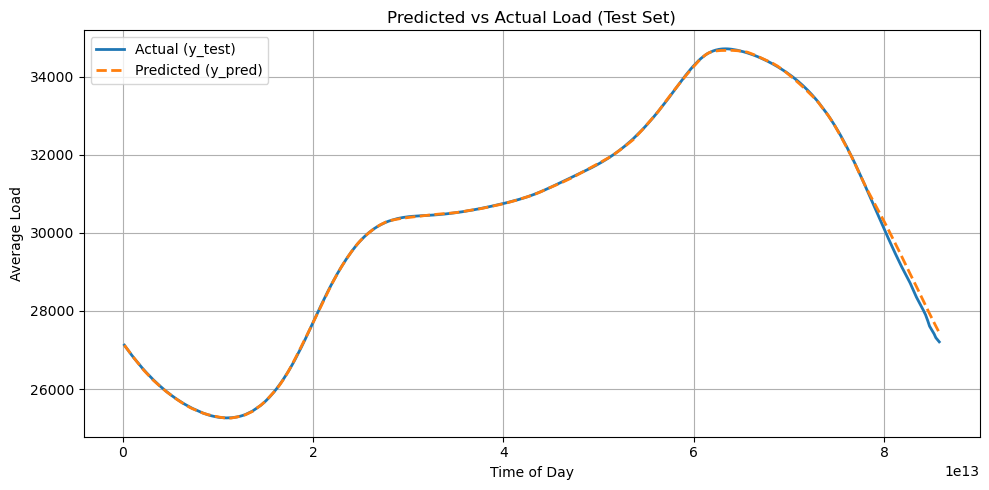

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(pd.to_timedelta(test_df['t_sec'], unit='s'), y_test, label='Actual (y_test)', linewidth=2)
plt.plot(pd.to_timedelta(test_df['t_sec'], unit='s'), y_pred, label='Predicted (y_pred)', linestyle='--', linewidth=2)
plt.xlabel('Time of Day')
plt.ylabel('Average Load')
plt.title('Predicted vs Actual Load (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()